# Cifar-10 dataset 
### Cifar-10 dataset se sastoji od 60 000 32x32 slika u boji. Postoji 10 klasa sa po 6000 slika, 5 000 za trening primere i 1000 za test primere.
### Dataset je podeljen u 5 trening batch-eva i 1 test batch, svaki sa po 10 000 slika.
### Cilj projekta je istrenirati model na trening podacima tako da na osnovu slike prepozna o kojoj se klasi radi, onda ga testirati na test podacima i odrediti tačnost modela.

In [1]:
import matplotlib.pyplot as plt 
import numpy as np

import torch 
import torchvision 
import torchvision.transforms as transforms 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

# Učitavanje i normalizacija podataka
   
   ### 1. Konvertovanje tipa PILimage koji dobijemo iz Cifar10 dataset-a u tensor
   ### 2. Normalizacija
   ###  - Normalizacija se radi da bi podatke stavili u odredjeni opseg cime se povećava preciznost i brzina neuronske mreže
   ###  - Pošto su PIL slike(opsega [0, 1]) u RGB formatu prosledjujemo 3 parametra za mean i za std
   ###  - Formulom x-mean/std dobijamo opseg [-1, 1]
   
   ### 3. batch_size je broj primera u jednoj iteraciji ili jednom forward/backward pass-u
   ### 4. num_workers odredjuje koliko procesa će se istovremeno odvijati za učitavanje podataka

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context    #zbog SSLCertVerificationError


transform = transforms.Compose( 
         [transforms.ToTensor(), # prvo se radi transformacija u tensore
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) ]) # onda se radi normalizacija tensora

batch_size = 4


num_workers = 2

# Ucitavanje trening skupa
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

# Ucitavanje test skupa
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

# Postojece klase
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


img, label = trainset[0]
print(img.shape, label)
img                #dimenzije tensora 32x32x3, 3 channel-a (RGB)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32]) 6


tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
         [-0.8431, -1.0000, -1.0000,  ..., -0

# Vizualizacija

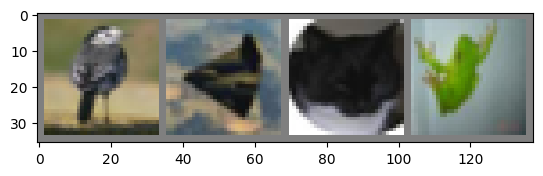

bird plane cat frog


In [3]:
def imgshow(img):
    img = img / 2 + 0.5  # zbog normalizacije, vraca se u prvobitni opseg
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# dobavljanje random trening primjeraka
dataiter = iter(trainloader)
images, labels = dataiter.next()

# prikaz slika
imgshow(torchvision.utils.make_grid(images))


# prikaz klasa
print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

# Konvolucijske neuronske mreze
### Arhitektura konvolucijske neuronske mreže se bolje uklapa u dataset slika zbog redukcije parametara i zbog iskoristivosti težina.
### Detektor odredjene osobine(npr. vertikalnih ivica) koji je koristan u jednom delu slike ce verovatno biti koristan i u nekom drugom.
### U svakom sloju, svaka izlazna vrednost zavisi od malog broja ulaza
### Cilj konvolucijske neuronske mreže je da smanji sliku u formu koje je lakša za obradu bez gubljenja vazžnih osobina koje su bitne za dobijanje dobrih predikcija.

## 1. Konvolucijski slojevi(conv)
###    argumenti: in_channels, out_channels, kernel_size
###    in_channels = 3 zato što je slika RGB
###    out_channels = 6 znači da će izlaz biti 6 feature mapa
###    kernel_size = 5 znači da će dimenzije kernela biti 5x5
###  Primećuje se da broj ulaza u narednom sloj mora biti jednak broju izlaza iz prethodnog sloja.

## 2. Max pooling
### - Koristi se da se smanje dimenzije slike(downsampling).
### - Korisno je za izvlačenje dominantnih osobina i smanjuje broj podataka koje treba obraditi, smanjuje šanse za overfiting.
### - Matrica koja se krece preko slike i izvlaci maksimalnu vrednost iz dela slike preko kojeg prelazi.
### - Dimenzije 2x2, stride=2(veličina koraka koji pravi prilkom kretanja)

## 3. Spojeni slojevi 
### - Svaki neuron iz prethodnog sloja će biti povezan sa svakim neuronom u narednom sloju
### - Obično se stavljaju kao zadnji slojevi u mreži
###   nn.Linear primenjuje linearnu transformaciju na ulazne podatke y = x * AT + b


## 4. Kernel - konvolucijska matrica 
### - Kernel se može zamisliti kao filter koji se primenjuje na sliku
### - Kernel(K) se kreće preko slike i u svakom koraku(stride) vrši matrično množenje izmedju K i dela slike preko kojeg trenutno prelazi i kao rezultat vraća mapu osobina(feature map)
### - U slučaju slika sa više kanala(channels), kernel mora imati istu dubinu kao i ulazna slika
### - Broj kernela može biti proizvoljan. Postojaće po jedan kernel(filter) za svaku osobinu koju želimo da nadjemo na slici, npr. jedan za horizontalne ivice, jedan za vertikalne itd.
### - Rezultat konovlucije će imati onoliko kanala koliko ima osobina koje tražimo


## 5. ReLu aktivaciona funkcija
### - Uvodi nelinearnost bez koje bi bilo teško obradjivati kompleksne podatke kao što su slike, audio...
### - Vraća 0 ako je ulaz manji od nule, u suprotnom vraća ulaz
###           f(x) = max(0, x)

In [4]:
class Net(nn.Module):    #LeNet-5
    
    def __init__(self):
        super(Net, self).__init__()
        #KONVOLUCIJSKI SLOJEVI
        self.conv1 = nn.Conv2d(3, 6, 5)    #in_channeles=3 zbog RGB,  out_channels=6 znaci da ce output imati 6 feature mapa, kernel_size=5 znaci konvolucijsko jezgro dimenzija 5x5
        
        self.pool = nn.MaxPool2d((2,2), 2)    #size=2x2, stride=2
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        
    
        #SPOJENI SLOJEVI
        self.fc1 = nn.Linear(16 * 5*5, 120)   # 5x5 za dimenzije slike, 10x10x16 je izlaz iz conv2 a nakon max poolinga se smanjuje u 5x5x16
        
        self.fc2 = nn.Linear(120, 84)
        
        self.fc3 = nn.Linear(84, 10)    #10 izlaza jer postoji 10 klasa
        
        
    def forward(self, x):
       
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # x = x.view(-1, 16 * 5 * 5)
        x = x.flatten(1)    #pretvatvatmo input u 1D
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.fc3(x)

        
        return x
    
    

class Net4(nn.Module):   
    def __init__(self):
        super(Net4, self).__init__()
        #KONVOLUCIJSKI SLOJEVI
        self.conv1 = nn.Conv2d(3, 32, 5)    #in_channeles=3 zbog RGB,  out_channels=6 znaci da ce output imati 6 feature mapa, kernel_size=5 znaci konvolucijsko jezgro dimenzija 5x5
        
        self.pool = nn.MaxPool2d((2,2), 2)    #size=2x2, stride=2
        
        self.conv2 = nn.Conv2d(32, 64, 5)
        
    
        #SPOJENI SLOJEVI
        self.fc1 = nn.Linear(64 * 5*5, 120)   # 5x5 za dimenzije slike, 10x10x16 je izlaz iz conv2 a nakon max poolinga se smanjuje u 5x5x16
        
        self.fc2 = nn.Linear(120, 84)
        
        self.fc3 = nn.Linear(84, 10)    #10 izlaza jer postoji 10 klasa
        
        
    def forward(self, x):
       
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # x = x.view(-1, 16 * 5 * 5)
        x = x.flatten(1)    #pretvatvatmo input u 1D
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.fc3(x)

        
        return x

net = Net4()
print(net)      


Net4(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Treniranje modela

## 6. CrossEntropyLoss
### - Standardna funkcija greške za višeklasne klasifikacione probleme
### - Kombinuje log softmax i Negative Log-Likelihood
### - softmax primenjuje eksponencijalnu funkciju na svaki element u ulazu i onda normalizuje te vrednosti tako što ih podeli sa sumom svih eksponenata, to osigurava da će suma svih elemenata u izlazu biti jednaka 1
### - logaritam od softmax funkcije stavlja sve vrednosti sa ulaza u opseg od -inf do 0
### - Negative Log-Likelihood  L(y) = -log(y), 
### - Ako dobije malu vrednost na ulaz može da dostigne beskonačan gubitak što daje slabu sigurnost za predikciju, u suprotnom ako dobije veliku vrednost gubitak je manji i sigurnost je veća

## 7. Optimizatori SGD, Adam
### - Algoritmi koji se koriste za ažuriranje težina i learning rate-a sa ciljem da se umanji greška

In [5]:
# #reload
# PATH = './cifar_net.pth'
# net.load_state_dict(torch.load(PATH))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
  
        optimizer.zero_grad() # postavljanje gradienta na 0 za svaki mini-batch da se ne bi akumulirali

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print 
        running_loss += loss.item()
        if i % 2000 == 1999:    # prikaz svkakih 2000 mini-batcheva
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Zavrseno treniranje')

#cuvanje modela
PATH = './cifar_net4.pth'
torch.save(net.state_dict(), PATH)

[1,  2000] loss: 2.081
[1,  4000] loss: 1.711
[1,  6000] loss: 1.539
[1,  8000] loss: 1.432
[1, 10000] loss: 1.380
[1, 12000] loss: 1.292
[2,  2000] loss: 1.205
[2,  4000] loss: 1.177
[2,  6000] loss: 1.128
[2,  8000] loss: 1.092
[2, 10000] loss: 1.094
[2, 12000] loss: 1.049
Zavrseno treniranje


## Testiranje

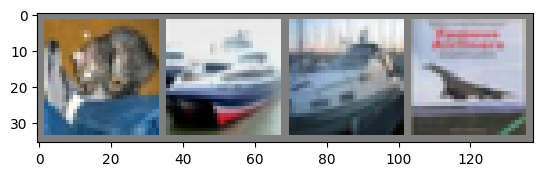

Klase:  cat ship ship plane


In [16]:
#reload
# PATH = './cifar_net3.pth'
# net.load_state_dict(torch.load(PATH))

dataiter = iter(testloader)

images, labels = dataiter.next()

# prikaz
imgshow(torchvision.utils.make_grid(images))
print('Klase: ', ' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

In [17]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predikcije: ', ' '.join('%s' % classes[predicted[j]] for j in range(batch_size)))

Predikcije:  cat ship ship plane


In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Preciznost na 10000 test primeraka: %d %%' % (100 * correct / total))

Preciznost na 10000 test primeraka: 62 %


In [19]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# bez gradienta
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # sakupljanje tacnih predikcija za svaku klasu
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# preciznost za svaku klasu
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Preciznost za klasu: {classname:5s} -> {accuracy:.1f} %')

Preciznost za klasu: plane -> 58.9 %
Preciznost za klasu: car   -> 70.2 %
Preciznost za klasu: bird  -> 27.5 %
Preciznost za klasu: cat   -> 32.9 %
Preciznost za klasu: deer  -> 55.6 %
Preciznost za klasu: dog   -> 78.3 %
Preciznost za klasu: frog  -> 76.7 %
Preciznost za klasu: horse -> 66.1 %
Preciznost za klasu: ship  -> 84.8 %
Preciznost za klasu: truck -> 73.1 %
